In [5]:
# python libraries
import os
import sys
import dataclasses
from datetime import datetime
from pathlib import Path
from operator import methodcaller
from collections import OrderedDict
from dataclasses import dataclass
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Mapping,
    Callable
)
from enum import Enum
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# numpy
import numpy as np

# torch
import torch
from torch import nn
from torch.nn import functional as F

try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

try:
    import torchinfo
except:
    print(f"[INFO] Installing the torchinfo")
    %pip install torchinfo
    import torchinfo

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper


## Connect Persistence memory
try :
    from google.colab import drive

    # Paths
    DRIVE_PATH = Path("/content/drive")
    MODEL_SAVE_PATH = Path("/content/drive/Othercomputers/My PC/drive/models")

    # mount drive
    drive.mount(str(DRIVE_PATH))
except:
    MODEL_SAVE_PATH = Path(os.getcwd())/"models"
    
device = "cuda" if torch.cuda.is_available() else "cpu"

# Basic Conv

In [4]:
class BasicConv2d(nn.Module):
    def __init__(self,num_channels,**kwargs) -> None:
        super().__init__()
        self.bc = nn.Sequential(
            nn.LazyConv2d(num_channels,**kwargs),
            nn.LazyBatchNorm2d()
        )
    def forward(self,x):
        return self.bc(x)
        

# Residual Block

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self,num_channels,use_1x1conv=False,stride=1) -> None:
        super().__init__()
        self.bc1 = BasicConv2d(num_channels,kernel_size=3,padding=1,stride=stride)
        #? Stride is not applied on g(x) for second time
        self.bc2 = BasicConv2d(num_channels,kernel_size=3,padding=1)
        if use_1x1conv:
            self.conv1x1 = nn.LazyConv2d(num_channels,kernel_size=1,padding=0,stride=stride)
        else:
            self.conv1x1 = None
    
    def forward(self,x):
        y = F.relu(self.bc1(x))
        y = self.bc2(y)
        if self.conv1x1:
            x = self.conv1x1(x)
        y += x
        return F.relu(y)

In [17]:
ResidualBlock(3)(torch.randn(4,3,6,6)).shape

torch.Size([4, 3, 6, 6])

In [13]:
ResidualBlock(3,use_1x1conv=True)(torch.randn(4,3,6,6)).shape

torch.Size([4, 3, 6, 6])

In [15]:
ResidualBlock(3,use_1x1conv=True,stride=2)(torch.randn(4,3,6,6)).shape

c:\Users\Lenovo\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 3, 3, 3])

# ResNet

In [30]:
class ResNet(helper.Classifier):
    
    def __init__(self,arch,lr=0.1,num_classes=10) -> None:
        super().__init__()
        self.arch = arch,
        self.lr = lr
        self.num_classes = num_classes
        
        self.net = nn.Sequential(self.b1())
        for i,b in enumerate(arch):
            self.net.add_module(f'{i+2}',self.block(*b,first_block=(i==0)))
        self.net.add_module("last",nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),
            nn.LazyLinear(num_classes)
        ))
    
    def b1(self):
        """This much similar to VGG"""
        return nn.Sequential(
            nn.LazyConv2d(64,kernel_size=7,stride=2,padding=3),
            nn.LazyBatchNorm2d(),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )
    
    def block(self,num_residuals,num_channels,first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(ResidualBlock(num_channels,use_1x1conv=True,stride=2))
            else:
                blk.append(ResidualBlock(num_channels))
        return nn.Sequential(*blk)
    
    def init_resnet(self,module):
        if isinstance(module,(nn.Linear,nn.Conv2d)):
            nn.init.kaiming_normal_(module.weight)

In [32]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10) -> None:
        super().__init__(((2,64),(2,128),(2,256),(2,512)), lr, num_classes)

In [29]:
torchinfo.summary(ResNet18(),input_size=(1,1,224,224)  ,  col_width=14,depth=2,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)

c:\Users\Lenovo\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type (var_name))                            Kernel Shape   Output Shape   Param #        Mult-Adds
ResNet18 (ResNet18)                                --             [1, 10]        --             --
├─Sequential (net)                                 --             [1, 10]        --             --
│    └─Sequential (0)                              --             [1, 64, 56, 56] 3,328          40,140,928
│    └─Sequential (2)                              --             [1, 64, 56, 56] 148,224        463,225,344
│    └─Sequential (3)                              --             [1, 128, 28, 28] 525,952        411,544,576
│    └─Sequential (4)                              --             [1, 256, 14, 14] 2,100,480      411,294,720
│    └─Sequential (5)                              --             [1, 512, 7, 7] 8,395,264      411,171,328
│    └─Sequential (last)                           --             [1, 10]        5,130          5,130
Total params: 11,178,378
Trainable params: 11,178

# Training the model

In [33]:
data = helper.FashionMNIST(batch_size=128,resize=(96,96))
model = ResNet18(lr=0.01)
model.apply_init([next(iter(data.train_dataloader()))[0]],model.init_resnet)


In [34]:
trainer = helper.Trainer(max_epochs=3,model_save_path=MODEL_SAVE_PATH,verbose=True)

Training the model in cpu


[INFO] Entering FIT
[INFO] Entering Data Preparation
[INFO] Entering Model Preparation
[INFO] Entering Plot Preparation


  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Start Fitting per epoch
	Batch 0\469 - Training Loss 4.033375263214111


KeyboardInterrupt: 

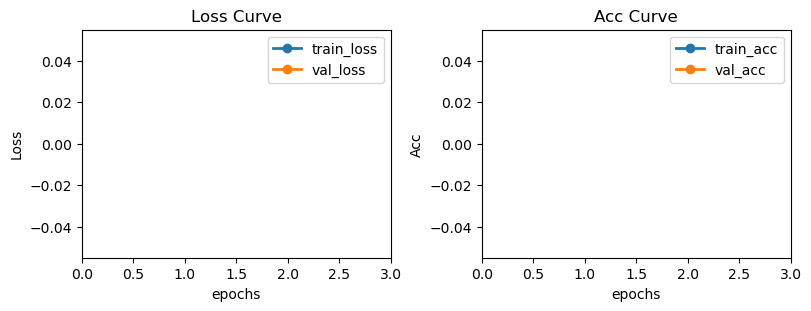

In [35]:
trainer.fit(model,data)